In [96]:
#check gpu
import tensorflow as tf
print(tf.__version__)
print(tf.test.is_gpu_available())


2.8.0
True


## Data preparation

In [97]:
# Import libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tqdm import tqdm
import matplotlib.pyplot as plt 
# 1. Load and Preprocess Data
csv_path = 'data-vn-20230228\stock-historical-data'

keywords = [
    "ABB", "ACB", "BID", "CTG", "EIB", "BVB", "HDB", "KLB", "LPB", "MBB", "MSB",
    "NAB", "BAB", "NVB", "OCB", "PGB", "SSB", "SGB", "SHB", "STB", "TCB", "TPB",
    "VAB", "VCB", "VIB", "VPB", "VBB"
]

# Load data
df_list = []
for file in os.listdir(csv_path):
    if any(keyword in file for keyword in keywords) and file.endswith('.csv'):
        file_path = os.path.join(csv_path, file)
        data = pd.read_csv(file_path, on_bad_lines='skip').dropna()
        data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
        df_list.append(data)

# Add Technical Indicators
def add_technical_indicators(df):
    df['SMA_20'] = df['Close'].rolling(window=20).mean()
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    return df

df_list = [add_technical_indicators(df) for df in df_list]

# Drop rows with missing values due to rolling calculations
df_list = [df.dropna().reset_index(drop=True) for df in df_list]

# Split into Train, Validation, and Test Sets
split_date_train = pd.Timestamp('2020-01-01')
split_date_val = pd.Timestamp('2021-01-01')
split_date_buffer = pd.Timestamp('2021-02-01')  # Buffer period

df_train_list, df_val_list, df_test_list = [], [], []
for df in df_list:
    train = df.loc[df['TradingDate'] < split_date_train]
    temp_test = df.loc[df['TradingDate'] >= split_date_train]
    val = temp_test.loc[temp_test['TradingDate'] < split_date_val]
    test = temp_test.loc[temp_test['TradingDate'] >= split_date_buffer]
    df_train_list.append(train)
    df_val_list.append(val)
    df_test_list.append(test)

C:\Users\nhata\AppData\Local\Temp\ipykernel_7872\2591029386.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_7872\2591029386.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_7872\2591029386.py:25: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['TradingDate'] = pd.to_datetime(data['TradingDate'], dayfirst=True, errors='coerce')
C:\Users\nhata\AppData\Local\Temp\ipykernel_7872\2591029386.py:25: UserWarning: Pa

In [98]:
# Function to normalize data with Min-Max scaling
def min_max_normalize(X_data, y_data=None):
    print("Normalizing data with Min-Max scaling...")
    X_norm = X_data.copy()
    y_norm = y_data.copy() if y_data is not None else None

    for i in range(len(X_data)):
        for j in range(X_data.shape[2]):
            min_feature = np.min(X_data[i][:, j])
            max_feature = np.max(X_data[i][:, j])
            X_norm[i][:, j] = (X_data[i][:, j] - min_feature) / (max_feature - min_feature) if max_feature > min_feature else 0
        if (i+1) % 100 == 0 or i == len(X_data) - 1:  # Print progress every 100 samples
            print(f"Processed normalization for sample {i+1}/{len(X_data)}")

    if y_data is not None:
        for i in range(len(y_data)):
            min_label = np.min(X_data[i][:, 1])
            max_label = np.max(X_data[i][:, 1])
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0

    print("Normalization complete.")
    return X_norm, y_norm

In [100]:
from tqdm import tqdm
import numpy as np

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples_k_days(df_list, window_size=90, predict_ahead=7):
    X_data_k_days = []
    y_data_k_days = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        # Adjust the loop to stop before the last few rows which cannot form a full window plus the prediction window
        for i in range(0, len(df) - window_size - predict_ahead + 1):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Select features including technical indicators
                data_feature = [
                    df.iloc[i + j]['Open'],       # Open price
                    df.iloc[i + j]['High'],       # High price
                    df.iloc[i + j]['Low'],        # Low price
                    df.iloc[i + j]['Close'],      # Close price
                    df.iloc[i + j]['Volume'],     # Volume
                    df.iloc[i + j]['SMA_20'],     # SMA 20
                    df.iloc[i + j]['SMA_50'],     # SMA 50
                    df.iloc[i + j]['EMA_12'],     # EMA 12
                    df.iloc[i + j]['EMA_26'],     # EMA 26
                    df.iloc[i + j]['MACD'],       # MACD
                    df.iloc[i + j]['RSI'],        # RSI
                ]
                current_feature.append(np.array(data_feature))

            # Collect the 'Open' prices for k consecutive days after the last day in the window
            data_label = [df.iloc[i + window_size + d, 1] for d in range(predict_ahead)]  # 'Open' is at index 1

            # Append new data sample (feature and label) to X_data and y_data
            X_data_k_days.append(np.array(current_feature).reshape(window_size, 11))
            y_data_k_days.append(np.array(data_label))

    return np.array(X_data_k_days), np.array(y_data_k_days)

# Define the window size and days ahead to predict
window_size = 90
k = 7  # Change this to the number of consecutive days you want to predict

# Generate training, validation, and test samples for k consecutive days
X_train_k_days, y_train_k_days = create_time_window_samples_k_days(df_train_list, window_size, k)
X_val_k_days, y_val_k_days = create_time_window_samples_k_days(df_val_list, window_size, k)
X_test_k_days, y_test_k_days = create_time_window_samples_k_days(df_test_list, window_size, k)

# Normalize the data
X_train_k_days_norm, y_train_k_days_norm = min_max_normalize(X_train_k_days, y_train_k_days)
X_val_k_days_norm, y_val_k_days_norm = min_max_normalize(X_val_k_days, y_val_k_days)
X_test_k_days_norm, y_test_k_days_norm = min_max_normalize(X_test_k_days, y_test_k_days)

Processing DataFrames: 100%|██████████| 27/27 [03:48<00:00,  8.47s/it]


Normalizing data with Min-Max scaling...
Processed normalization for sample 100/20302
Processed normalization for sample 200/20302
Processed normalization for sample 300/20302
Processed normalization for sample 400/20302
Processed normalization for sample 500/20302
Processed normalization for sample 600/20302
Processed normalization for sample 700/20302
Processed normalization for sample 800/20302
Processed normalization for sample 900/20302
Processed normalization for sample 1000/20302
Processed normalization for sample 1100/20302
Processed normalization for sample 1200/20302
Processed normalization for sample 1300/20302
Processed normalization for sample 1400/20302
Processed normalization for sample 1500/20302
Processed normalization for sample 1600/20302
Processed normalization for sample 1700/20302
Processed normalization for sample 1800/20302
Processed normalization for sample 1900/20302
Processed normalization for sample 2000/20302
Processed normalization for sample 2100/20302
Pr

## Train LSTM model

Epoch 1/50
40/40 [==============================] - 4s 62ms/step - loss: 0.0756 - val_loss: 0.0532
Epoch 2/50
40/40 [==============================] - 2s 53ms/step - loss: 0.0464 - val_loss: 0.0477
Epoch 3/50
40/40 [==============================] - 2s 57ms/step - loss: 0.0418 - val_loss: 0.0458
Epoch 4/50
40/40 [==============================] - 2s 53ms/step - loss: 0.0391 - val_loss: 0.0435
Epoch 5/50
40/40 [==============================] - 2s 52ms/step - loss: 0.0379 - val_loss: 0.0434
Epoch 6/50
40/40 [==============================] - 2s 54ms/step - loss: 0.0364 - val_loss: 0.0485
Epoch 7/50
40/40 [==============================] - 2s 53ms/step - loss: 0.0352 - val_loss: 0.0573
Epoch 8/50
40/40 [==============================] - 2s 54ms/step - loss: 0.0345 - val_loss: 0.0428
Epoch 9/50
40/40 [==============================] - 2s 55ms/step - loss: 0.0336 - val_loss: 0.0414
Epoch 10/50
40/40 [==============================] - 2s 53ms/step - loss: 0.0346 - val_loss: 0.0412
Epoch 11/

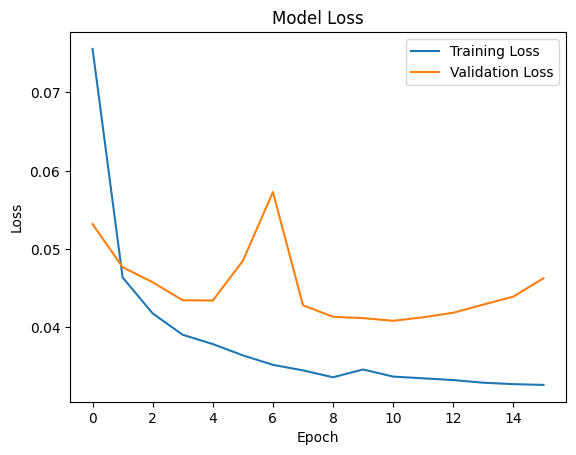

In [ ]:
# create LSTM model

#import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(window_size, 11), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(k))  # Output layer to predict k days ahead
model.compile(optimizer='adam', loss='mean_squared_error')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

# Train the model
history = model.fit(X_train_k_days_norm, y_train_k_days_norm, epochs=50, batch_size=512, validation_data=(X_val_k_days_norm, y_val_k_days_norm), callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test_k_days_norm, y_test_k_days_norm)
print(f"Test Loss: {loss}")

# plot the result
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


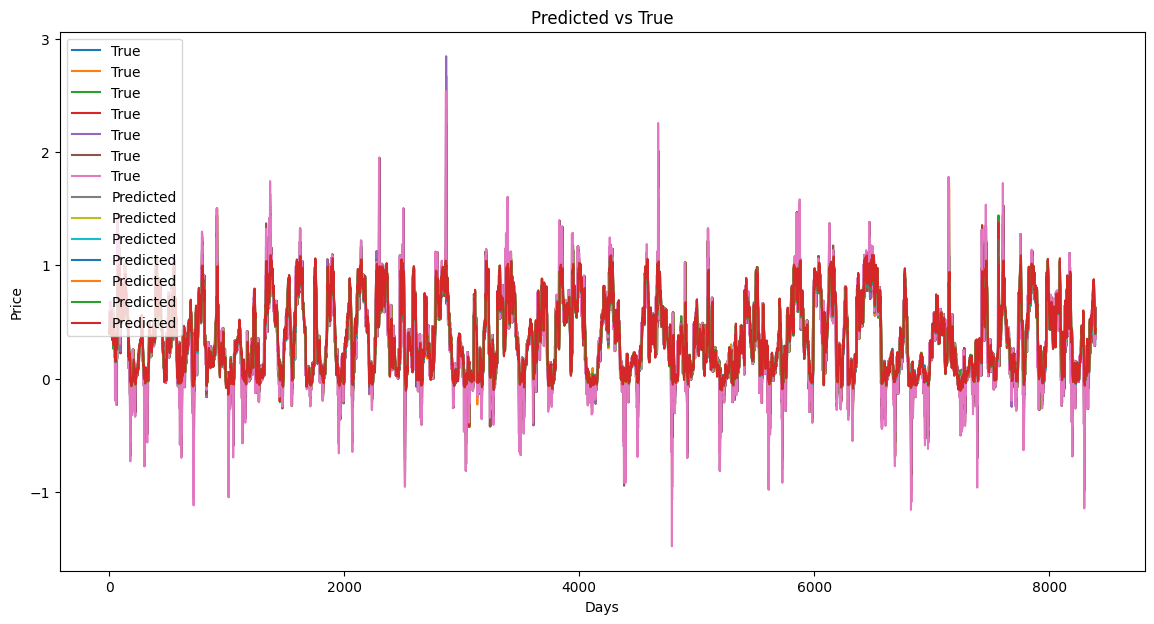

In [ ]:
# plot the prediction
y_pred = model.predict(X_test_k_days_norm)
plt.figure(figsize=(14, 7))
plt.plot(y_test_k_days_norm, label='True')
plt.plot(y_pred, label='Predicted')
plt.title('Predicted vs True')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend()
plt.show()

## Task 4.1 and 4.2: Calculate the percentage change of the stock price

In [118]:
import numpy as np

def calculate_percentage_change(y_pred, y_test, company_names):
    """
    Calculates the percentage change between the latest day in the test set and the predicted value for the 7th day.
    
    Args:
    - y_pred: Array of predicted prices (shape: [samples, 7])
    - y_test: Array of true prices (shape: [samples, 7])
    - company_names: List of company names corresponding to the samples.
    
    Returns:
    - percentage_changes_dict: Dictionary containing percentage change for each company.
    """
    percentage_changes_dict = {}

    for idx, company in enumerate(company_names):
        # Extract the latest true price and the predicted 7th day price
        latest_true_price = y_test[idx, -1]  # Last day in the test set
        predicted_7th_day_price = y_pred[idx, -1]  # 7th day prediction

        # Calculate percentage change
        percentage_change = ((predicted_7th_day_price - latest_true_price) / latest_true_price) * 100

        # Store the result in a dictionary
        percentage_changes_dict[company] = percentage_change

    return percentage_changes_dict


In [119]:
# Assume you have these variables:
# y_pred: Predicted prices for all companies, shape (27, 7)
# y_test_k_days_rescaled: True prices for all companies, shape (27, 7)
# company_names: List of company names corresponding to the predictions

company_names=keywords

# Call the function
percentage_changes = calculate_percentage_change(y_pred, y_test_k_days_norm, company_names)

# Print percentage change for each company
for company, change in percentage_changes.items():
    print(f"Company: {company}")
    print(f"Percentage Change (%): {change:.2f}%")


Company: ABB
Percentage Change (%): -19.71%
Company: ACB
Percentage Change (%): -23.88%
Company: BID
Percentage Change (%): -23.77%
Company: CTG
Percentage Change (%): -34.17%
Company: EIB
Percentage Change (%): -32.02%
Company: BVB
Percentage Change (%): -34.33%
Company: HDB
Percentage Change (%): -27.51%
Company: KLB
Percentage Change (%): -17.26%
Company: LPB
Percentage Change (%): -20.43%
Company: MBB
Percentage Change (%): -13.65%
Company: MSB
Percentage Change (%): -13.30%
Company: NAB
Percentage Change (%): -8.95%
Company: BAB
Percentage Change (%): -13.08%
Company: NVB
Percentage Change (%): -18.54%
Company: OCB
Percentage Change (%): -12.59%
Company: PGB
Percentage Change (%): -4.48%
Company: SSB
Percentage Change (%): 20.98%
Company: SGB
Percentage Change (%): 32.73%
Company: SHB
Percentage Change (%): 30.17%
Company: STB
Percentage Change (%): 38.14%
Company: TCB
Percentage Change (%): 52.51%
Company: TPB
Percentage Change (%): 32.62%
Company: VAB
Percentage Change (%): 13.1

In [116]:
# Check the shape of y_test and y_pred
print(f"y_test shape: {y_test_k_days_norm.shape}, y_pred shape: {y_pred.shape}")

# Inspect a few samples of y_test and y_pred
print("y_test (last true prices):", y_test_k_days_norm[:, -1])
print("y_pred (7th day predictions):", y_pred[:, -1])


y_test shape: (8394, 7), y_pred shape: (8394, 7)
y_test (last true prices): [0.5126294  0.56300897 0.57142857 ... 0.46       0.35       0.38      ]
y_pred (7th day predictions): [0.411588   0.4285751  0.43560666 ... 0.39850193 0.44531363 0.44333822]


## Task 4.3: Create a Portfolio Optimization based on Combined Score of Percentage Change and Risk Range 

In [135]:
def rank_companies_with_balanced_score(y_pred, y_test, company_names, top_n=7, weight_return=0.7, weight_risk=0.3):
    """
    Ranks companies based on a combined score that balances percentage change and risk.
    
    Args:
    - y_pred: Array of predicted daily prices for all companies, shape (companies, 7).
    - y_test: Array of true prices for all companies, shape (companies, 7).
    - company_names: List of company names corresponding to the predictions.
    - top_n: Number of top companies to include in the ranking table.
    - weight_return: Weight assigned to percentage change (default: 0.7).
    - weight_risk: Weight assigned to risk (default: 0.3).

    Returns:
    - ranked_table: A pandas DataFrame containing the top N companies with metrics.
    """
    company_metrics = []

    for idx, company in enumerate(company_names):
        prices = y_pred[idx]
        latest_true_price = y_test[idx, -1]
        predicted_7th_day_price = y_pred[idx, -1]

        # Calculate Percentage Change
        if latest_true_price != 0:  # Avoid division by zero
            percentage_change = ((predicted_7th_day_price - latest_true_price) / latest_true_price) * 100
        else:
            percentage_change = 0  # Assign 0% if the true price is 0

        # Calculate Risk as Price Range
        risk_range = max(prices) - min(prices)

        # Store metrics
        company_metrics.append({
            "Company": company,
            "Percentage Change (%)": percentage_change,
            "Risk (Range)": risk_range
        })

    # Create a DataFrame
    df = pd.DataFrame(company_metrics)

    # Normalize metrics
    df["Normalized Return"] = (df["Percentage Change (%)"] - df["Percentage Change (%)"].min()) / (
        df["Percentage Change (%)"].max() - df["Percentage Change (%)"].min()
    )
    df["Normalized Risk"] = (df["Risk (Range)"] - df["Risk (Range)"].min()) / (
        df["Risk (Range)"].max() - df["Risk (Range)"].min()
    )

    # Calculate Combined Score
    df["Combined Score"] = (weight_return * df["Normalized Return"]) + (weight_risk * (1 - df["Normalized Risk"]))

    # Rank by Combined Score
    ranked_table = df.sort_values(by="Combined Score", ascending=False).head(top_n).reset_index(drop=True)

    return ranked_table


In [136]:
# Call the function
top_companies = rank_companies_with_balanced_score(y_pred, y_test_k_days_norm, company_names, top_n=7)

# Print the ranked table
print(top_companies)


  Company  Percentage Change (%)  Risk (Range)  Normalized Return  \
0     TCB              52.512569      0.003478           1.000000   
1     STB              38.140216      0.003474           0.834508   
2     SGB              32.731899      0.005720           0.772234   
3     TPB              32.618554      0.005860           0.770929   
4     SHB              30.169615      0.004926           0.742730   
5     SSB              20.975712      0.004370           0.636866   
6     VAB              13.169431      0.009095           0.546980   

   Normalized Risk  Combined Score  
0         0.000191        0.999943  
1         0.000000        0.884156  
2         0.113948        0.806379  
3         0.121052        0.803335  
4         0.073672        0.797810  
5         0.045472        0.732165  
6         0.285200        0.597326  
